# Project 2: SOFR Futures and Policy Expectations

**Data**: `project_sofr_futures_20251231.xlsx`, `project_fomc_dates.xlsx`, `project_gsw_yields_20251231.xlsx`, `ref_rates.xlsx`

---

## Project Statement

Use SOFR futures to extract and analyze market expectations of Federal Reserve policy during the 2022–2024 rate cycle. Investigate how accurately futures predicted realized rates, how expectations repriced around FOMC meetings, and how front-end rate surprises transmitted to longer Treasury yields.

---

## Context

### SOFR Futures and Policy Expectations

**SOFR futures** are exchange-traded contracts that settle to the Secured Overnight Financing Rate. Because SOFR closely tracks the Fed Funds target rate, SOFR futures prices encode market expectations about future monetary policy.

The standard price quote is:
$$\text{Price} = 100 - \text{Implied Rate}$$

So a price of 95.25 implies an expected rate of 4.75%.

**3-Month SOFR Futures (SR3)** settle to the compounded average of daily SOFR over the contract quarter. The implied rate reflects market expectations of the average policy rate during that quarter.

### The 2022–2024 Policy Cycle

The Fed's 2022–24 hiking cycle was the most aggressive in decades:

| Date | Event |
|------|-------|
| March 2022 | First hike (25 bp) |
| June 2022 | 75 bp hike—largest since 1994 |
| July 2023 | Peak at 5.25–5.50% |
| March 2023 | SVB collapse—markets suddenly price cuts |
| December 2023 | Powell signals rate cuts ahead |
| September 2024 | First cut (50 bp) |

Markets frequently repriced expectations as inflation data evolved, creating significant futures price volatility and providing rich data for analysis.

### Contract Mechanics

**Ticker convention**: SR3 + month code + year digit
- H = March, M = June, U = September, Z = December
- Example: SR3H4 = March 2024 contract

**Contract specifications**:
- Notional: \$1,000,000
- **DV01: \$25 per basis point** (for one contract)
- Settlement: Compounded SOFR over the contract quarter
- The DV01 is useful for converting rate changes to dollar P\&L

### Data Overview

The validated data spans a rich period for analysis:

| Metric | Value |
|--------|-------|
| **Trading days** | ~750 (2022–2025) |
| **Contracts** | 20 (SR3H2 through SR3Z6) |
| **FOMC meetings** | 24 in 2022–2024 |
| **Key events** | June 2022 (75bp surprise), SVB (Mar 2023), Powell pivot (Dec 2023) |

---

## Resources

### Course Materials
- **Discussion 3.1**: STIR Futures — mechanics, pricing, settlement conventions
- **Discussion 3.2**: Inferring FF Futures — extracting policy expectations from futures
- **Discussion 3.3**: Discount via SOFR Futures — building discount curves, convexity adjustment
- **Appendix 3.X.1**: Convexity Adjustment

### External Reading
- CME Group: [SOFR Futures and Options](https://www.cmegroup.com/markets/interest-rates/stirs/three-month-sofr.html) — contract specifications
- CME FedWatch Tool: [CME FedWatch](https://www.cmegroup.com/markets/interest-rates/cme-fedwatch-tool.html) — methodology for extracting meeting probabilities
- NY Fed: [SOFR](https://www.newyorkfed.org/markets/reference-rates/sofr) — rate calculation methodology
- Federal Reserve: [FOMC Calendars](https://www.federalreserve.gov/monetarypolicy/fomccalendars.htm)

### Data Files

| File | Description | Sheets | Date Range |
|------|-------------|--------|------------|
| `project_sofr_futures_20251231.xlsx` | SOFR 3M futures | `prices`, `implied_rates`, `contract_info` | 2022–2025 |
| `project_fomc_dates.xlsx` | FOMC meeting dates | — | 2015–2025 |
| `project_gsw_yields_20251231.xlsx` | Treasury yields (GSW) | `gsw_yields_key`, `gsw_changes` | 2015–2025 |
| `ref_rates.xlsx` | SOFR, Fed Funds effective | `data` | 2018–2025 |

**Data location**: All files are in the `../data/` directory relative to this notebook.

### Additional Data Sources
- **FRED**: Fed Funds effective rate (DFF), target range (DFEDTARU, DFEDTARL)
- **CME**: Volume and open interest data (optional)

---

## Data Preview

The following code loads the data and creates initial visualizations.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

pd.set_option('display.max_columns', 15)
figsize = (12, 5)

DATA_PATH = os.getcwd() + '/data/'

In [2]:
# Load SOFR futures data
sofr_prices = pd.read_excel(DATA_PATH + 'project_sofr_futures_20251231.xlsx', sheet_name='prices')
sofr_prices['date'] = pd.to_datetime(sofr_prices['date'])
sofr_prices = sofr_prices.set_index('date').sort_index()

sofr_rates = pd.read_excel(DATA_PATH + 'project_sofr_futures_20251231.xlsx', sheet_name='implied_rates')
sofr_rates['date'] = pd.to_datetime(sofr_rates['date'])
sofr_rates = sofr_rates.set_index('date').sort_index()

contract_info = pd.read_excel(DATA_PATH + 'project_sofr_futures_20251231.xlsx', sheet_name='contract_info')
contract_info['expiry_date'] = pd.to_datetime(contract_info['expiry_date'])

print(f"SOFR Futures: {sofr_rates.shape[0]} trading days, {sofr_rates.shape[1]} contracts")
print(f"Date range: {sofr_rates.index.min().date()} to {sofr_rates.index.max().date()}")

# List contracts sorted by expiry
tickers = contract_info.sort_values('expiry_date')['ticker'].tolist()
print(f"\nContracts: {tickers[:5]} ... {tickers[-3:]}")
display(contract_info.head())

SOFR Futures: 1244 trading days, 20 contracts
Date range: 2022-01-02 to 2025-12-30

Contracts: ['SR3H2', 'SR3M2', 'SR3U2', 'SR3Z2', 'SR3H3'] ... ['SR3M6', 'SR3U6', 'SR3Z6']


,ticker,expiry_month,expiry_year,expiry_date
0,SR3H2,3,2022,2022-03-16
1,SR3M2,6,2022,2022-06-15
2,SR3U2,9,2022,2022-09-21
3,SR3Z2,12,2022,2022-12-21
4,SR3H3,3,2023,2023-03-15


In [3]:
# Load FOMC dates
fomc = pd.read_excel(DATA_PATH + 'project_fomc_dates.xlsx')
fomc['date'] = pd.to_datetime(fomc['date'])

# Filter to relevant period (2022-2024)
fomc_sample = fomc[(fomc['year'] >= 2022) & (fomc['year'] <= 2024)].copy()
print(f"FOMC meetings 2022-2024: {len(fomc_sample)}")
print(f"\nMeetings by year:")
print(fomc_sample.groupby('year').size())
display(fomc_sample.head(10))

FOMC meetings 2022-2024: 24

Meetings by year:
year
2022    8
2023    8
2024    8
dtype: int64


,date,year,month
57,2022-01-26,2022,1
58,2022-03-16,2022,3
59,2022-05-04,2022,5
60,2022-06-15,2022,6
61,2022-07-27,2022,7
62,2022-09-21,2022,9
63,2022-11-02,2022,11
64,2022-12-14,2022,12
65,2023-02-01,2023,2
66,2023-03-22,2023,3


In [4]:
# Load Treasury yields (GSW)
gsw_yields = pd.read_excel(DATA_PATH + 'project_gsw_yields_20251231.xlsx', sheet_name='gsw_yields_key')
gsw_yields['date'] = pd.to_datetime(gsw_yields['date'])
gsw_yields = gsw_yields.set_index('date').sort_index()

# Filter to relevant period
gsw_yields = gsw_yields['2022':'2024']
print(f"GSW Treasury yields: {gsw_yields.shape[0]} days")
print(f"Maturities: {list(gsw_yields.columns)}")
display(gsw_yields.tail())

GSW Treasury yields: 782 days
Maturities: ['2Y', '5Y', '10Y']


,2Y,5Y,10Y
date,,,
2024-12-25,NaN,NaN,NaN
2024-12-26,4.3167,4.3464,4.6474
2024-12-27,4.3173,4.3635,4.6736
2024-12-30,4.2635,4.3034,4.6215
2024-12-31,4.2545,4.3000,4.6264


In [5]:
# Load reference rates (SOFR, Fed Funds) - needed for forecast accuracy in Q3
ref_rates = pd.read_excel(DATA_PATH + 'ref_rates.xlsx', sheet_name='data')
ref_rates['date'] = pd.to_datetime(ref_rates['date'])
ref_rates = ref_rates.set_index('date').sort_index()

print(f"Reference rates: {ref_rates.shape[0]} days")
print(f"Columns: {list(ref_rates.columns)}")
ref_rates.tail()

Reference rates: 2922 days
Columns: ['DTB3', 'DFF', 'SOFR']


,DTB3,DFF,SOFR
date,,,
2025-12-27,NaN,3.64,NaN
2025-12-28,NaN,3.64,NaN
2025-12-29,3.57,3.64,3.77
2025-12-30,3.55,3.64,3.71
2025-12-31,3.57,3.64,3.87


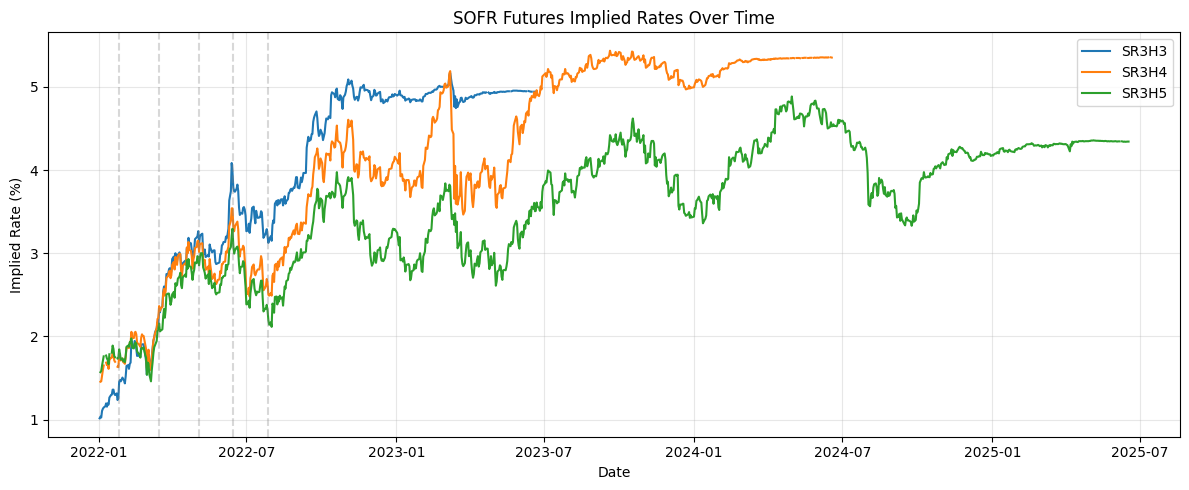

In [6]:
# Figure 1: Evolution of rate expectations
# Plot implied rate for contracts at different horizons

fig, ax = plt.subplots(figsize=figsize)

# Select a few contracts to show expectations at different horizons
contracts_to_plot = ['SR3H3', 'SR3H4', 'SR3H5']  # March 2023, 2024, 2025

for ticker in contracts_to_plot:
    if ticker in sofr_rates.columns:
        ax.plot(sofr_rates.index, sofr_rates[ticker], label=ticker, linewidth=1.5)

# Mark FOMC dates
for d in fomc_sample['date'][:5]:  # First 5 meetings
    ax.axvline(d, color='gray', alpha=0.3, linestyle='--')

ax.set_xlabel('Date')
ax.set_ylabel('Implied Rate (%)')
ax.set_title('SOFR Futures Implied Rates Over Time')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

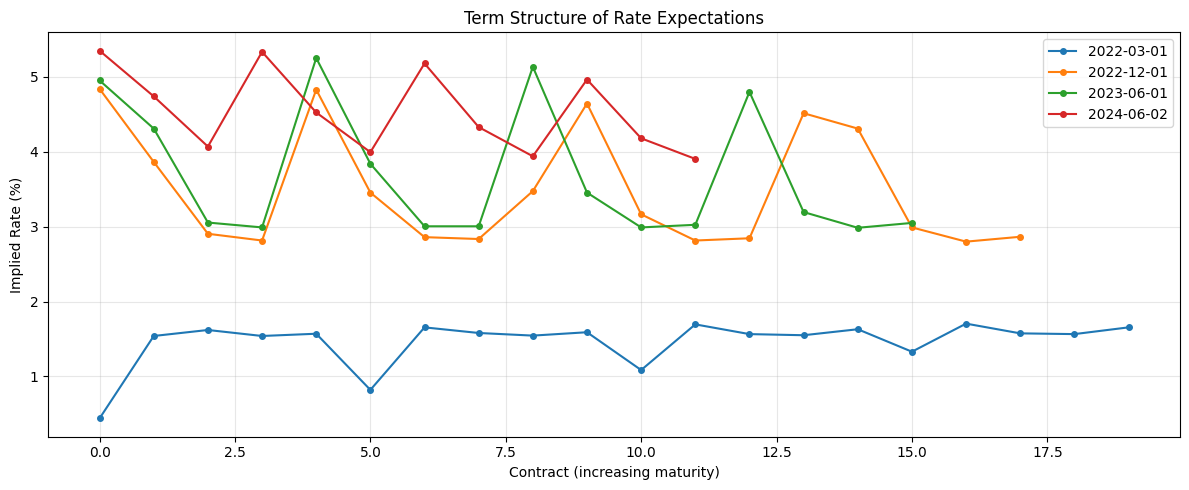

In [7]:
# Figure 2: Policy expectations curve at different dates
# Shows the term structure of expected rates

snapshot_dates = ['2022-03-01', '2022-12-01', '2023-06-01', '2024-06-01']

fig, ax = plt.subplots(figsize=figsize)

for date_str in snapshot_dates:
    date = pd.Timestamp(date_str)
    # Find nearest trading day
    if date not in sofr_rates.index:
        date = sofr_rates.index[sofr_rates.index.get_indexer([date], method='nearest')[0]]
    
    # Get rates for all contracts on this date
    rates = sofr_rates.loc[date].dropna()
    
    # Convert contract names to numeric for plotting
    x = range(len(rates))
    ax.plot(x, rates.values, 'o-', label=str(date.date()), markersize=4)

ax.set_xlabel('Contract (increasing maturity)')
ax.set_ylabel('Implied Rate (%)')
ax.set_title('Term Structure of Rate Expectations')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

---

## Key Formulas

The following formulas are essential for this project. Refer back to **Discussion 3.1** and **3.2** for derivations.

### Implied Rate from Futures Price

$$r^{\text{implied}} = 100 - P$$

where $P$ is the futures price. Note: When the price goes **up**, the implied rate goes **down**.

### FOMC Meeting Probability Extraction

For a month with an FOMC meeting on day $m$ (out of $D$ total days):

$$r^{\text{implied}} = \frac{m}{D} \times r^{\text{before}} + \frac{D-m}{D} \times r^{\text{after}}$$

Solving for the expected post-meeting rate:

$$r^{\text{after}} = \frac{D \times r^{\text{implied}} - m \times r^{\text{before}}}{D - m}$$

### Policy Surprise

$$\text{Surprise} = r^{\text{actual}} - r^{\text{expected}}$$

A positive surprise means the Fed was more hawkish than expected.

### Forecast Error

$$\text{Error}_t^{(h)} = r_{t+h}^{\text{actual}} - r_t^{\text{implied}(h)}$$

where $h$ is the forecast horizon (e.g., 3 months, 6 months).

---

## Questions

Address the following questions in your analysis.

### Question 1: Building the Expectations Curve

**Construct and visualize how rate expectations evolved over the 2022–2024 cycle.**

a) For **four snapshot dates** spanning the cycle, extract implied rates from all available SOFR futures contracts and plot the "expected rate path." Choose dates that capture different phases of the policy cycle.

b) Identify key milestones in expectations:
   - When did markets first price a terminal rate above 5%?
   - When did expectations for rate cuts first appear?
   - Track how the expected terminal rate (maximum implied rate across all contracts) evolved over time.

c) Create a time series of the **terminal rate** (peak of the expectations curve each day). Plot it alongside key events (FOMC dates, SVB collapse).

*Guidance*: The implied rates are already calculated in the data (`implied_rates` sheet). Use the `contract_info` sheet to map contract tickers to expiry dates for proper x-axis labeling.

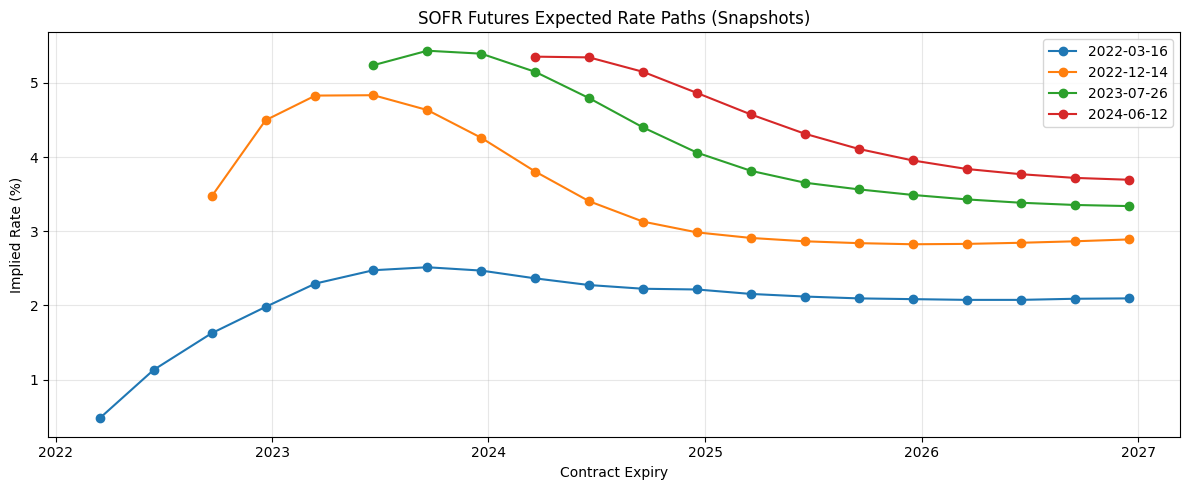

First date terminal > 5%: 2022-11-01
First date cuts priced (peak>=5% and curve declines): 2022-11-01


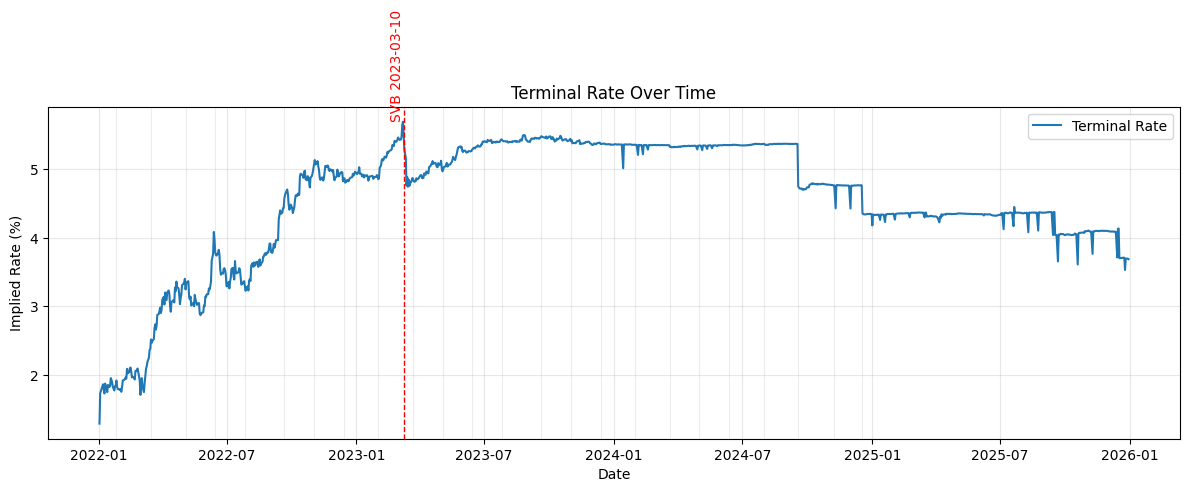

In [8]:
# Q1: Building the Expectations Curve
# Uses objects created in the Data Preview section: sofr_rates, contract_info, fomc_sample, figsize

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Part (a): Snapshot curves ---
# Four snapshot dates spanning the cycle
snapshot_targets = [
    pd.Timestamp('2022-03-16'),
    pd.Timestamp('2022-12-14'),
    pd.Timestamp('2023-07-26'),
    pd.Timestamp('2024-06-12'),
]

# Map tickers to expiry dates for x-axis ordering
expiry_map = dict(zip(contract_info['ticker'], contract_info['expiry_date']))

# Helper: nearest trading day in data
available_dates = sofr_rates.index

def nearest_trading_day(ts):
    return available_dates[available_dates.get_indexer([ts], method='nearest')[0]]

snapshots = []
for target in snapshot_targets:
    snap_date = nearest_trading_day(target)
    rates = sofr_rates.loc[snap_date].dropna()
    df = rates.to_frame('implied_rate')
    df['expiry'] = df.index.map(expiry_map)
    df = df.dropna(subset=['expiry']).sort_values('expiry')
    snapshots.append((snap_date, df))

fig, ax = plt.subplots(figsize=figsize)
for snap_date, df in snapshots:
    ax.plot(df['expiry'], df['implied_rate'], marker='o', label=snap_date.strftime('%Y-%m-%d'))
ax.set_title('SOFR Futures Expected Rate Paths (Snapshots)')
ax.set_xlabel('Contract Expiry')
ax.set_ylabel('Implied Rate (%)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# --- Part (b): Key milestones ---
# Terminal rate = max implied rate across all contracts each day
terminal_rate = sofr_rates.max(axis=1)

# First date terminal rate > 5%
first_gt5 = terminal_rate[terminal_rate > 5].index.min()

# First date where cuts appear (definition: peak >=5%, not at last contract, tail >=25bp below peak)
cuts_date = None
for dt, row in sofr_rates.iterrows():
    vals = row.dropna()
    if vals.empty:
        continue
    ordered = vals.to_frame('rate')
    ordered['expiry'] = ordered.index.map(expiry_map)
    ordered = ordered.dropna().sort_values('expiry')
    if len(ordered) < 6:
        continue
    peak = ordered['rate'].max()
    last = ordered['rate'].iloc[-1]
    peak_idx = ordered['rate'].values.argmax()
    if peak >= 5.0 and peak_idx < len(ordered)-1 and (peak - last) >= 0.25:
        cuts_date = dt
        break

print('First date terminal > 5%:', first_gt5.date() if first_gt5 is not None else None)
print('First date cuts priced (peak>=5% and curve declines):', cuts_date.date() if cuts_date is not None else None)

# --- Part (c): Terminal rate over time with events ---
terminal_series = terminal_rate.rename('terminal_rate').to_frame()

fig, ax = plt.subplots(figsize=figsize)
ax.plot(terminal_series.index, terminal_series['terminal_rate'], label='Terminal Rate')

# Add FOMC vertical lines
for d in fomc_sample['date']:
    ax.axvline(d, color='gray', alpha=0.15, linewidth=0.8)

# Add SVB marker
svb_date = pd.Timestamp('2023-03-10')
ax.axvline(svb_date, color='red', linestyle='--', linewidth=1)
ax.text(svb_date, terminal_series['terminal_rate'].max(), 'SVB 2023-03-10',
        rotation=90, va='bottom', ha='right', color='red')

ax.set_title('Terminal Rate Over Time')
ax.set_xlabel('Date')
ax.set_ylabel('Implied Rate (%)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()





### Question 2: FOMC Meeting Surprises

**Analyze how futures prices responded to FOMC meetings.**

a) For each FOMC meeting in 2022–2024, calculate:
   - The front-month implied rate the day **before** the meeting
   - The front-month implied rate the day **after** the meeting
   - The 1-day change (surprise component)

b) Classify each meeting as:
   - **Hawkish surprise**: implied rate rose more than 5 bp
   - **Dovish surprise**: implied rate fell more than 5 bp
   - **As expected**: change within ±5 bp

   Create a bar chart showing the surprise for each meeting, color-coded by classification.

c) For the **2–3 meetings with the largest surprises**, show how the full futures curve (all contracts) repriced. Did a hawkish front-end surprise raise or lower expectations for rates 1–2 years ahead?

*Guidance*: Use **trading days**, not calendar days. The "front-month" contract is the one with the nearest expiry date still in the future.

,meeting_date,before,after,contract,r_before,r_after,surprise_bp,classification
0,2022-01-26,2022-01-25,2022-01-27,SR3H2,0.3650,0.4400,7.50,Hawkish surprise
1,2022-03-16,2022-03-15,2022-03-17,SR3H2,0.5125,0.4550,-5.75,Dovish surprise
2,2022-05-04,2022-05-03,2022-05-05,SR3M2,1.6600,1.6250,-3.50,As expected
3,2022-06-15,2022-06-14,2022-06-16,SR3M2,1.9000,1.8950,-0.50,As expected
4,2022-07-27,2022-07-26,2022-07-28,SR3U2,3.0950,3.0050,-9.00,Dovish surprise
5,2022-09-21,2022-09-20,2022-09-22,SR3U2,3.4625,3.4375,-2.50,As expected
6,2022-11-02,2022-11-01,2022-11-03,SR3Z2,4.6150,4.6350,2.00,As expected
7,2022-12-14,2022-12-13,2022-12-15,SR3Z2,4.5025,4.4975,-0.50,As expected
8,2023-02-01,2023-01-31,2023-02-02,SR3H3,4.8400,4.8250,-1.50,As expected
9,2023-03-22,2023-03-21,2023-03-23,SR3M3,4.8000,4.6100,-19.00,Dovish surprise


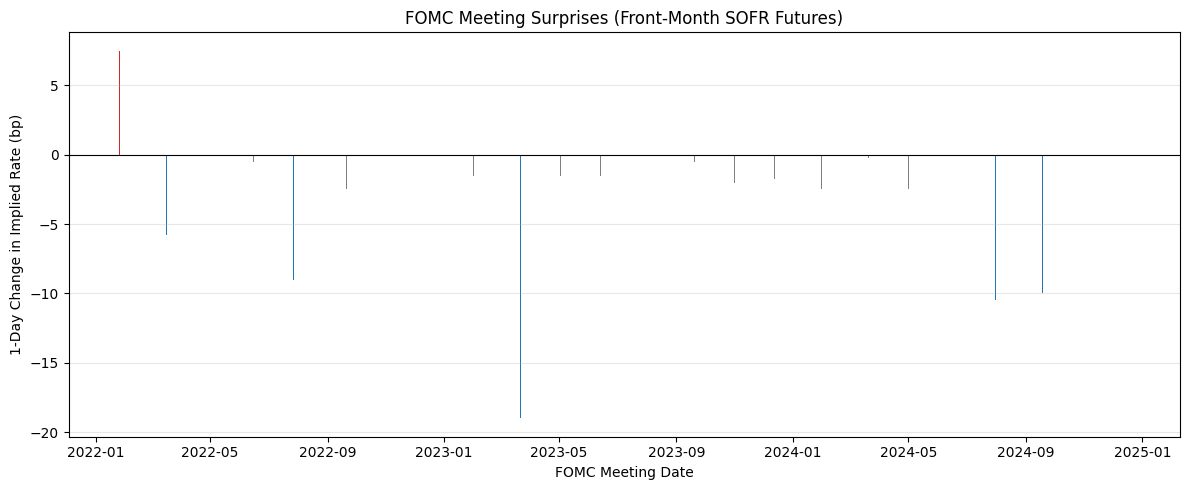

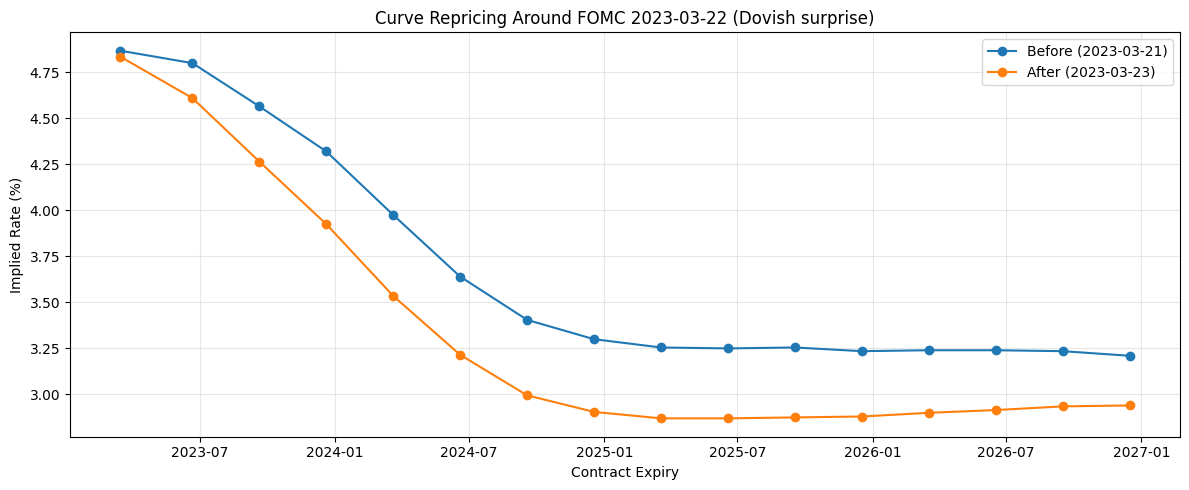

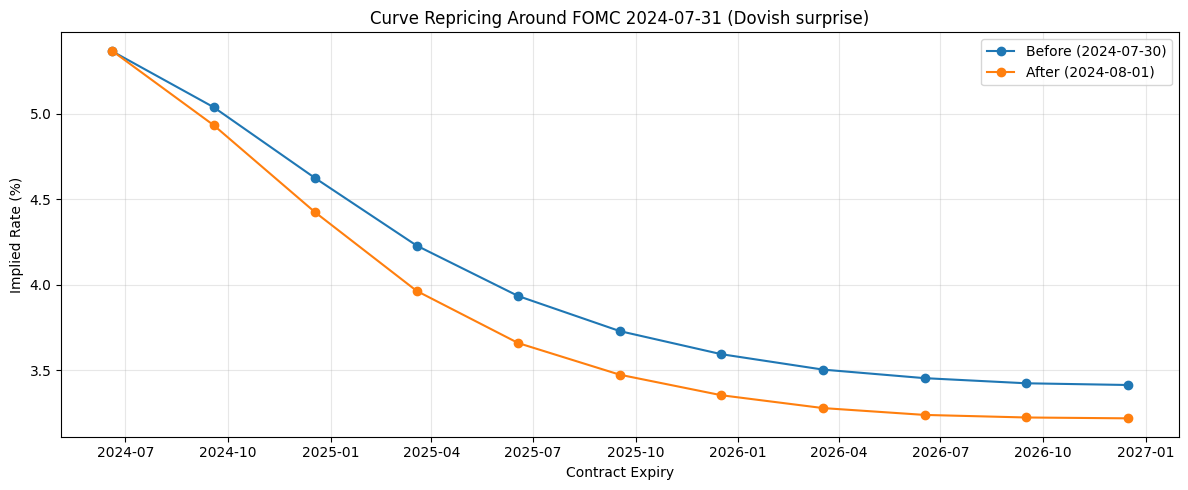

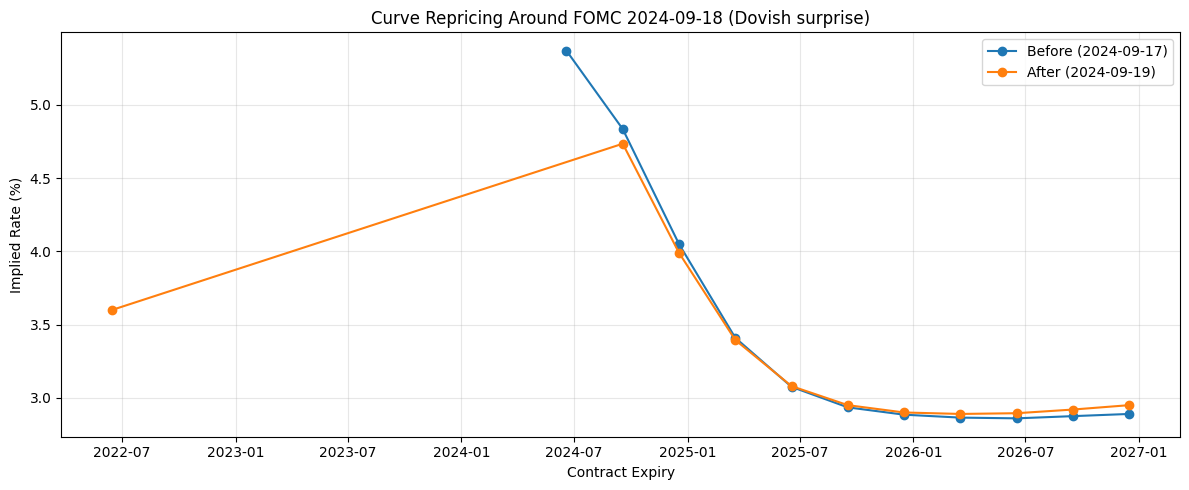

,meeting_date,before,after,contract,r_before,r_after,surprise,classification
0,2022-01-26,2022-01-25,2022-01-27,SR3H2,0.3650,0.4400,0.0750,Hawkish surprise
1,2022-03-16,2022-03-15,2022-03-17,SR3H2,0.5125,0.4550,-0.0575,Dovish surprise
2,2022-05-04,2022-05-03,2022-05-05,SR3M2,1.6600,1.6250,-0.0350,As expected
3,2022-06-15,2022-06-14,2022-06-16,SR3M2,1.9000,1.8950,-0.0050,As expected
4,2022-07-27,2022-07-26,2022-07-28,SR3U2,3.0950,3.0050,-0.0900,Dovish surprise
5,2022-09-21,2022-09-20,2022-09-22,SR3U2,3.4625,3.4375,-0.0250,As expected
6,2022-11-02,2022-11-01,2022-11-03,SR3Z2,4.6150,4.6350,0.0200,As expected
7,2022-12-14,2022-12-13,2022-12-15,SR3Z2,4.5025,4.4975,-0.0050,As expected
8,2023-02-01,2023-01-31,2023-02-02,SR3H3,4.8400,4.8250,-0.0150,As expected
9,2023-03-22,2023-03-21,2023-03-23,SR3M3,4.8000,4.6100,-0.1900,Dovish surprise


In [9]:
# Q2: FOMC Meeting Surprises
# Uses objects created in the Data Preview section: sofr_rates, contract_info, fomc_sample, figsize

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Map tickers to expiry dates for front-month identification
expiry_map = dict(zip(contract_info['ticker'], contract_info['expiry_date']))

# Helper: get nearest trading day before/after a given date
trading_days = sofr_rates.index

def prev_trading_day(dt):
    pos = trading_days.searchsorted(dt) - 1
    if pos < 0:
        return None
    return trading_days[pos]


def next_trading_day(dt):
    pos = trading_days.searchsorted(dt, side='right')
    if pos >= len(trading_days):
        return None
    return trading_days[pos]


def front_month_contract(asof_date):
    # Contract with nearest expiry strictly after the asof_date
    future_contracts = [(t, d) for t, d in expiry_map.items() if pd.notna(d) and d.date() > asof_date.date()]
    if not future_contracts:
        return None
    return min(future_contracts, key=lambda x: x[1])[0]

# Build meeting surprise table
rows = []
for _, row in fomc_sample.iterrows():
    meeting_date = row['date']
    before = prev_trading_day(meeting_date)
    after = next_trading_day(meeting_date)
    if before is None or after is None:
        continue
    contract = front_month_contract(before)
    if contract is None or contract not in sofr_rates.columns:
        continue
    r_before = sofr_rates.at[before, contract]
    r_after = sofr_rates.at[after, contract]
    if pd.isna(r_before) or pd.isna(r_after):
        continue
    surprise = r_after - r_before
    rows.append({
        'meeting_date': meeting_date,
        'before': before,
        'after': after,
        'contract': contract,
        'r_before': r_before,
        'r_after': r_after,
        'surprise': surprise,
    })

surprises = pd.DataFrame(rows).sort_values('meeting_date')

# Classify surprises (bp thresholds)
conditions = [
    surprises['surprise'] > 0.05,
    surprises['surprise'] < -0.05,
]
choices = ['Hawkish surprise', 'Dovish surprise']
surprises['classification'] = np.select(conditions, choices, default='As expected')

# Table view (in bp)
surprise_table = surprises.copy()
surprise_table['surprise_bp'] = surprise_table['surprise'] * 100
surprise_table = surprise_table[['meeting_date', 'before', 'after', 'contract', 'r_before', 'r_after', 'surprise_bp', 'classification']]

# Display table
display(surprise_table)

# Bar chart of surprises
color_map = {
    'Hawkish surprise': '#d62728',
    'Dovish surprise': '#1f77b4',
    'As expected': '#7f7f7f'
}

fig, ax = plt.subplots(figsize=figsize)
colors = surprises['classification'].map(color_map)
ax.bar(surprises['meeting_date'], surprises['surprise']*100, color=colors)
ax.axhline(0, color='black', linewidth=0.8)
ax.set_title('FOMC Meeting Surprises (Front-Month SOFR Futures)')
ax.set_xlabel('FOMC Meeting Date')
ax.set_ylabel('1-Day Change in Implied Rate (bp)')
ax.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# --- Part (c): Largest surprises (full curve repricing) ---
# Pick 3 largest surprises by absolute magnitude
largest = surprises.reindex(surprises['surprise'].abs().sort_values(ascending=False).index).head(3)

for _, m in largest.iterrows():
    before = m['before']
    after = m['after']
    
    # Get full curves, ordered by expiry
    before_curve = sofr_rates.loc[before].dropna().to_frame('rate')
    before_curve['expiry'] = before_curve.index.map(expiry_map)
    before_curve = before_curve.dropna().sort_values('expiry')

    after_curve = sofr_rates.loc[after].dropna().to_frame('rate')
    after_curve['expiry'] = after_curve.index.map(expiry_map)
    after_curve = after_curve.dropna().sort_values('expiry')

    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(before_curve['expiry'], before_curve['rate'], 'o-', label=f'Before ({before.date()})')
    ax.plot(after_curve['expiry'], after_curve['rate'], 'o-', label=f'After ({after.date()})')
    ax.set_title(f'Curve Repricing Around FOMC {m["meeting_date"].date()} ({m["classification"]})')
    ax.set_xlabel('Contract Expiry')
    ax.set_ylabel('Implied Rate (%)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Display table for review
surprises.head(10)




### Question 3: Forecast Accuracy

**Evaluate how well futures predicted realized rates.**

a) For each month in 2022–2024, calculate the forecast error at the **3-month horizon**:
   $$\text{Error}_t^{(3)} = r_{t+3}^{\text{actual}} - r_t^{\text{implied}(3)}$$
   
   Use the implied rate from the front SOFR futures contract and compare to the realized average SOFR during the contract's reference quarter (from `ref_rates.xlsx`).

b) Compute summary statistics:
   - **Mean error (bias)**: Were futures systematically too high or too low?
   - **RMSE**: Root mean squared error
   - **Directional accuracy**: What percentage of the time did futures correctly predict whether rates would rise or fall?

c) Split your sample into two regimes:
   - **Hiking phase** (March 2022 – July 2023)
   - **Plateau/cutting phase** (August 2023 – December 2024)
   
   Compare forecast accuracy across regimes. Create a table showing bias and RMSE for each regime.

d) **Interpret**: If futures have predictable biases, what does this suggest about risk premia or behavioral biases in rate expectations?

*Guidance*: The realized rate for a contract should be the average SOFR during the contract's reference quarter, not just a single day.

In [10]:
# Q3: Forecast Accuracy
# Uses objects created in the Data Preview section: sofr_rates, contract_info, ref_rates

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Map tickers to expiry dates for reference-quarter identification
expiry_map = dict(zip(contract_info['ticker'], contract_info['expiry_date']))

# Helper: front-month contract as of a date
trading_days = sofr_rates.index

def front_month_contract(asof_date):
    future_contracts = [(t, d) for t, d in expiry_map.items() if pd.notna(d) and d.date() > asof_date.date()]
    if not future_contracts:
        return None
    return min(future_contracts, key=lambda x: x[1])[0]

# Helper: get ref rate value on or before a date
ref_series = None
if 'SOFR' in ref_rates.columns:
    ref_series = ref_rates['SOFR']
else:
    # fall back to first column
    ref_series = ref_rates.iloc[:, 0]

ref_series = ref_series.sort_index()

def ref_on_or_before(dt):
    pos = ref_series.index.searchsorted(dt, side='right') - 1
    if pos < 0:
        return np.nan
    return ref_series.iloc[pos]

# Build monthly sample (first trading day of each month in 2022-2024)
monthly_dates = (
    pd.Series(sofr_rates.index)
    .groupby([sofr_rates.index.year, sofr_rates.index.month])
    .min()
)
monthly_dates = [d for d in monthly_dates if pd.Timestamp('2022-01-01') <= d <= pd.Timestamp('2024-12-31')]

rows = []
for d in monthly_dates:
    contract = front_month_contract(d)
    if contract is None or contract not in sofr_rates.columns:
        continue
    implied = sofr_rates.at[d, contract]
    if pd.isna(implied):
        continue
    expiry = expiry_map.get(contract)
    if pd.isna(expiry):
        continue

    # Reference quarter: 3-month window ending in the contract month
    q_end = pd.Timestamp(expiry).normalize().replace(day=1) + pd.offsets.MonthEnd(0)
    q_start = (q_end - pd.offsets.MonthBegin(3)) + pd.offsets.MonthBegin(0)

    # Realized average SOFR over the reference quarter
    daily = ref_series.loc[q_start:q_end].dropna()
    if daily.empty:
        continue

    # Simple average (arithmetic)
    realized_simple = daily.mean()

    # Compounded average (approx): compound daily simple rates
    # Convert annualized percent to daily rate assuming ACT/360
    daily_rates = daily / 100.0
    accrual = (1 + daily_rates / 360.0).prod()
    realized_comp = (accrual - 1) * 360.0 / len(daily) * 100.0

    current_ref = ref_on_or_before(d)

    error = realized_comp - implied
    # Directional accuracy: compare implied change vs actual change from current ref
    implied_change = implied - current_ref if pd.notna(current_ref) else np.nan
    actual_change = realized - current_ref if pd.notna(current_ref) else np.nan
    direction_correct = np.sign(implied_change) == np.sign(actual_change) if pd.notna(implied_change) and pd.notna(actual_change) else np.nan

    rows.append({
        'date': d,
        'contract': contract,
        'expiry': expiry,
        'implied_rate': implied,
        'realized_simple': realized_simple,
        'realized_comp': realized_comp,
        'error': error,
        'direction_correct': direction_correct,
        'regime': 'Hiking' if d <= pd.Timestamp('2023-07-31') else 'Plateau/Cutting'
    })

errors = pd.DataFrame(rows).sort_values('date')

# Summary statistics
mean_error = errors['error'].mean()
rmse = np.sqrt((errors['error'] ** 2).mean())
directional_accuracy = errors['direction_correct'].mean() * 100

print('Overall mean error (bias):', round(mean_error, 4))
print('Overall RMSE:', round(rmse, 4))
print('Directional accuracy (%):', round(directional_accuracy, 2))

# Regime comparison
regime_stats = errors.groupby('regime').agg(
    bias=('error', 'mean'),
    rmse=('error', lambda x: np.sqrt((x**2).mean())),
    n_obs=('error', 'count')
).reset_index()

print('Regime stats:')
display(regime_stats)

# Plot forecast errors over time
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(errors['date'], errors['error']*100, label='Forecast Error (bp)')
ax.axhline(0, color='black', linewidth=0.8)
ax.set_title('3-Month Horizon Forecast Error (SOFR Futures, Compounded)')
ax.set_xlabel('Date')
ax.set_ylabel('Error (bp)')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Show sample rows
errors.head(10)




NameError: name 'realized' is not defined

### Question 4: Transmission to the Treasury Curve

**Analyze how front-end rate surprises affected longer-term Treasury yields.**

a) For each FOMC meeting, calculate the 1-day change in:
   - The front-month SOFR futures implied rate (your "surprise" from Q2)
   - The 2-year, 5-year, and 10-year Treasury yields (from `gsw_yields_key` sheet)

b) Create scatter plots with front-end surprise on the x-axis and Treasury yield change on the y-axis. Fit a regression line to estimate the **transmission beta**:
   $$\Delta y^{(n)} = \alpha + \beta \cdot \Delta r^{\text{front}} + \varepsilon$$
   
   where $n \in \{2Y, 5Y, 10Y\}$.

c) Report the transmission betas and R² for each maturity. How does transmission differ across maturities?

d) Identify any meetings where the transmission pattern was unusual (e.g., front-end up but long-end down). What might explain these cases?

*Guidance*: The GSW data columns are labeled by maturity in years (e.g., '2', '5', '10').

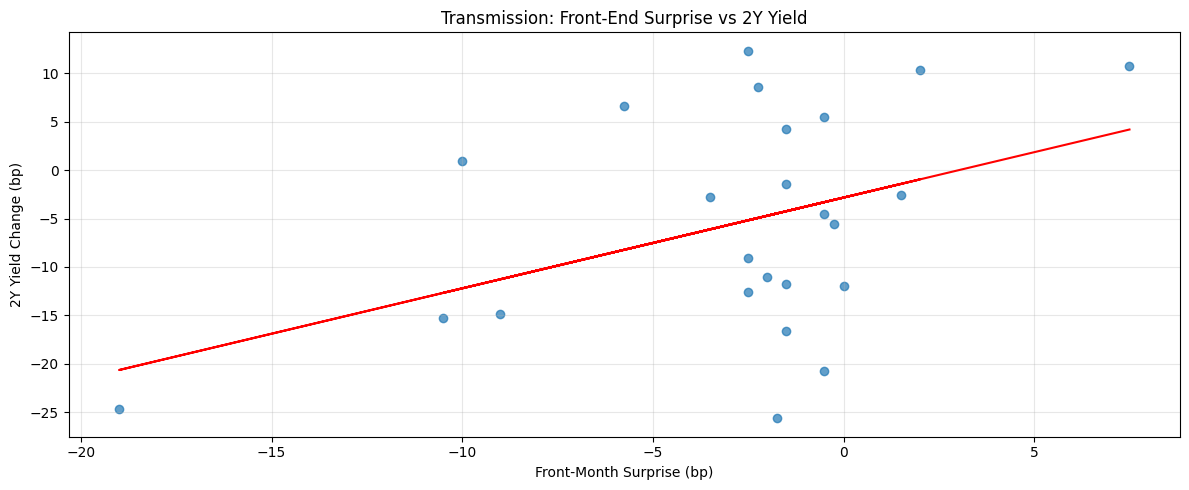

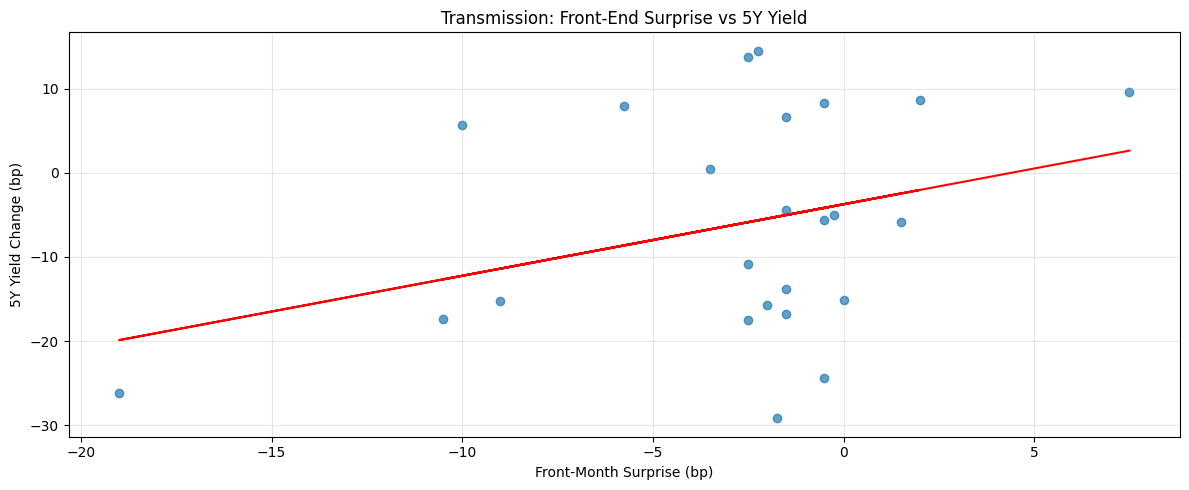

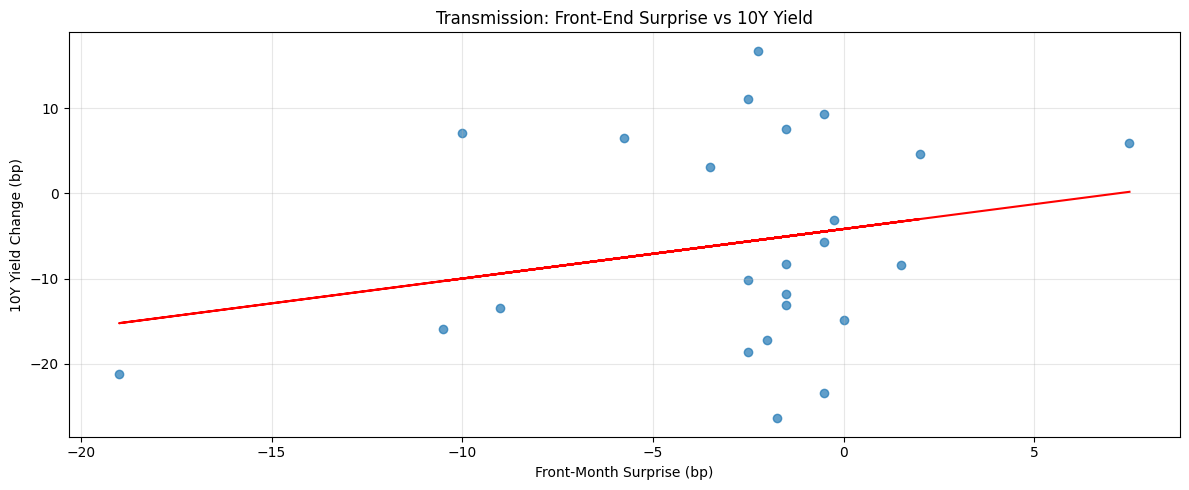

Transmission betas and R²:


,maturity,alpha,beta,r2
0,2Y,-2.827144,0.937920,0.180978
1,5Y,-3.750464,0.849542,0.109276
2,10Y,-4.175201,0.581694,0.059230


Largest 2Y residuals (unusual transmission):


,meeting_date,front_surprise,d2y,d5y,d10y,resid_2y_bp
15,2023-12-13,-0.0175,-0.2564,-0.2918,-0.2639,-21.171496
5,2022-09-21,-0.0250,0.1235,0.1372,0.1108,17.521943
3,2022-06-15,-0.0050,-0.2071,-0.2443,-0.2338,-17.413896
1,2022-03-16,-0.0575,0.0659,0.0794,0.0645,14.810182
23,2024-12-18,-0.0225,0.0856,0.1449,0.1674,13.497464


In [ ]:
# Q4: Transmission to the Treasury Curve
# Uses objects created in the Data Preview section: sofr_rates, contract_info, fomc_sample, gsw_yields, figsize

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Map tickers to expiry dates for front-month identification
expiry_map = dict(zip(contract_info['ticker'], contract_info['expiry_date']))

# Helper: get nearest trading day before/after a given date
trading_days = sofr_rates.index

def prev_trading_day(dt):
    pos = trading_days.searchsorted(dt) - 1
    if pos < 0:
        return None
    return trading_days[pos]


def next_trading_day(dt):
    pos = trading_days.searchsorted(dt, side='right')
    if pos >= len(trading_days):
        return None
    return trading_days[pos]


def front_month_contract(asof_date):
    future_contracts = [(t, d) for t, d in expiry_map.items() if pd.notna(d) and d.date() > asof_date.date()]
    if not future_contracts:
        return None
    return min(future_contracts, key=lambda x: x[1])[0]

# Build meeting surprise + yield changes
rows = []
for _, row in fomc_sample.iterrows():
    meeting_date = row['date']
    before = prev_trading_day(meeting_date)
    after = next_trading_day(meeting_date)
    if before is None or after is None:
        continue

    # Front-month SOFR implied rate change
    contract = front_month_contract(before)
    if contract is None or contract not in sofr_rates.columns:
        continue
    r_before = sofr_rates.at[before, contract]
    r_after = sofr_rates.at[after, contract]
    if pd.isna(r_before) or pd.isna(r_after):
        continue
    front_surprise = r_after - r_before

    # Treasury yield changes
    if before not in gsw_yields.index or after not in gsw_yields.index:
        continue
    y_before = gsw_yields.loc[before]
    y_after = gsw_yields.loc[after]

    rows.append({
        'meeting_date': meeting_date,
        'before': before,
        'after': after,
        'front_surprise': front_surprise,
        'd2y': y_after['2Y'] - y_before['2Y'],
        'd5y': y_after['5Y'] - y_before['5Y'],
        'd10y': y_after['10Y'] - y_before['10Y'],
    })

surprise_df = pd.DataFrame(rows).sort_values('meeting_date')

# Scatter plots + regressions
maturities = [('2Y', 'd2y', '2Y'), ('5Y', 'd5y', '5Y'), ('10Y', 'd10y', '10Y')]
results = []

for _, col, label in maturities:
    x = surprise_df['front_surprise'] * 100  # bp
    y = surprise_df[col] * 100  # bp

    # OLS via polyfit
    beta, alpha = np.polyfit(x, y, 1)
    y_hat = alpha + beta * x
    ss_res = np.sum((y - y_hat) ** 2)
    ss_tot = np.sum((y - y.mean()) ** 2)
    r2 = 1 - ss_res / ss_tot if ss_tot != 0 else np.nan

    results.append({'maturity': label, 'alpha': alpha, 'beta': beta, 'r2': r2})

    fig, ax = plt.subplots(figsize=figsize)
    ax.scatter(x, y, alpha=0.7)
    ax.plot(x, y_hat, color='red', linewidth=1.5)
    ax.set_title(f'Transmission: Front-End Surprise vs {label} Yield')
    ax.set_xlabel('Front-Month Surprise (bp)')
    ax.set_ylabel(f'{label} Yield Change (bp)')
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Report betas and R2
results_df = pd.DataFrame(results)
print('Transmission betas and R²:')
display(results_df)

# Identify unusual meetings: large residuals in 2Y regression
# (You can change maturity if you want to focus on another part of the curve.)
x = surprise_df['front_surprise'] * 100
y = surprise_df['d2y'] * 100
beta, alpha = np.polyfit(x, y, 1)
residuals = y - (alpha + beta * x)

surprise_df['resid_2y_bp'] = residuals
unusual = surprise_df.reindex(residuals.abs().sort_values(ascending=False).index).head(5)

print('Largest 2Y residuals (unusual transmission):')
display(unusual[['meeting_date', 'front_surprise', 'd2y', 'd5y', 'd10y', 'resid_2y_bp']])




### Question 5: Event Deep-Dive

**Analyze how expectations repriced around a major market event.**

Choose **one** of the following events:

| Event | Date | Description |
|-------|------|-------------|
| **SVB Collapse** | March 10, 2023 | Banking stress triggers sudden repricing of rate expectations |
| **Powell Pivot** | December 13, 2023 | Fed signals rate cuts ahead |

For your chosen event:

a) Plot the **full SOFR futures curve** (all available contracts) at three points:
   - 1 week before the event
   - Day after the event
   - 1 month after the event

b) Quantify the repricing:
   - How much did the expected **terminal rate** change? (Peak of the curve)
   - How much did **near-term expectations** (average of first 2 contracts) change?
   - Calculate a **persistence ratio**: (1-month shift) / (immediate shift). Values near 1.0 mean the repricing was persistent; values near 0 mean it largely reversed.

c) **Interpret**: What does the pattern of repricing tell you about how markets process new information?

*Guidance*: Focus on telling a clear story with your visualizations. Annotate your plots to highlight the key shifts.

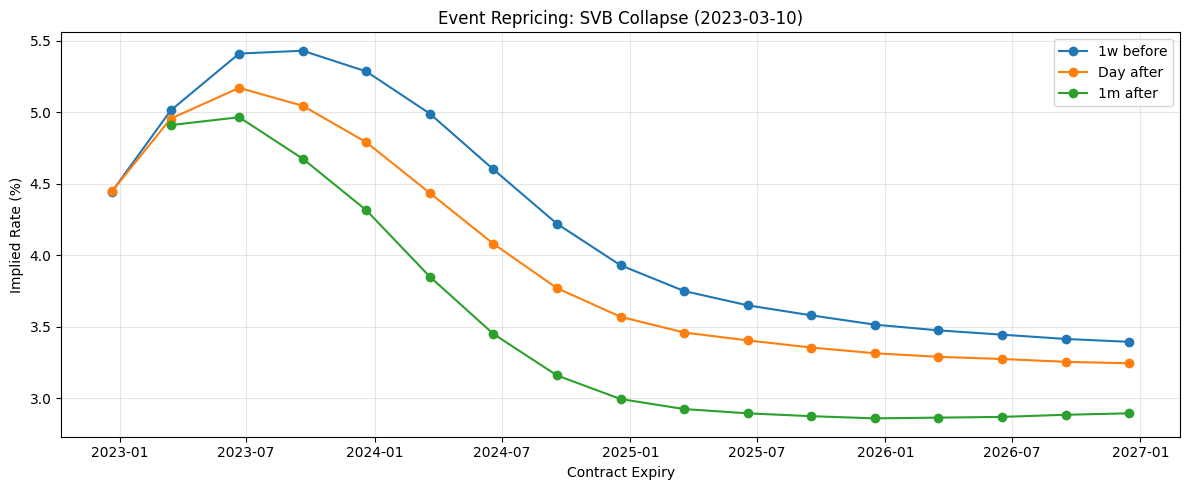

Terminal rate change (immediate): -0.26
Terminal rate change (1m): -0.465
Near-term change (immediate): -0.0275
Near-term change (1m): 0.2088
Persistence ratio: 1.7885


In [ ]:
# Q5: Event Deep-Dive
# Uses objects created in the Data Preview section: sofr_rates, contract_info, figsize

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Verify labels in sof_rates (do not assume) ---
cols = list(sofr_rates.columns)
if 'date' in cols:
    # If date is a column, set it as index
    sofr_rates = sofr_rates.set_index('date')

# Identify contract columns (all columns in the DataFrame)
contract_cols = list(sofr_rates.columns)

# Map tickers to expiry dates for ordering
expiry_map = dict(zip(contract_info['ticker'], contract_info['expiry_date']))

# --- Choose event ---
# Options: 'SVB' or 'Powell'
event = 'SVB'

if event == 'SVB':
    event_date = pd.Timestamp('2023-03-10')
    event_label = 'SVB Collapse'
elif event == 'Powell':
    event_date = pd.Timestamp('2023-12-13')
    event_label = 'Powell Pivot'
else:
    raise ValueError('Unknown event')

# Helper: nearest trading day in data
trading_days = sofr_rates.index

def nearest_trading_day(ts):
    return trading_days[trading_days.get_indexer([ts], method='nearest')[0]]

# Dates for comparison
one_week_before = nearest_trading_day(event_date - pd.Timedelta(days=7))
day_after = nearest_trading_day(event_date + pd.Timedelta(days=1))
one_month_after = nearest_trading_day(event_date + pd.DateOffset(months=1))

snap_dates = [one_week_before, day_after, one_month_after]
labels = ['1w before', 'Day after', '1m after']

# Build curves ordered by expiry
curves = []
for d in snap_dates:
    rates = sofr_rates.loc[d, contract_cols].dropna()
    df = rates.to_frame('rate')
    df['expiry'] = df.index.map(expiry_map)
    df = df.dropna().sort_values('expiry')
    curves.append(df)

# Plot full curves
fig, ax = plt.subplots(figsize=figsize)
for df, lab in zip(curves, labels):
    ax.plot(df['expiry'], df['rate'], 'o-', label=lab)
ax.set_title(f'Event Repricing: {event_label} ({event_date.date()})')
ax.set_xlabel('Contract Expiry')
ax.set_ylabel('Implied Rate (%)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Quantify repricing
# Terminal rate (peak)
terminal_before = curves[0]['rate'].max()
terminal_after = curves[1]['rate'].max()
terminal_1m = curves[2]['rate'].max()

# Near-term expectations: average of first 2 contracts
near_before = curves[0]['rate'].iloc[:2].mean()
near_after = curves[1]['rate'].iloc[:2].mean()
near_1m = curves[2]['rate'].iloc[:2].mean()

# Persistence ratio
immediate_shift = terminal_after - terminal_before
one_month_shift = terminal_1m - terminal_before
persistence_ratio = one_month_shift / immediate_shift if immediate_shift != 0 else np.nan

print('Terminal rate change (immediate):', round(immediate_shift, 4))
print('Terminal rate change (1m):', round(one_month_shift, 4))
print('Near-term change (immediate):', round(near_after - near_before, 4))
print('Near-term change (1m):', round(near_1m - near_before, 4))
print('Persistence ratio:', round(persistence_ratio, 4))



### Question 6: Trading Strategy

**Design and backtest a simple trading strategy on SOFR futures.**

a) Implement a **carry strategy**: maintain a long position in the 2nd contract (roughly 6 months out). When the 2nd contract becomes the front contract, roll to the new 2nd contract.

   Use the contract DV01 of \$25 per basis point to compute daily P\&L:
   $$\text{P\&L}_t = -\Delta r_t \times 100 \times \$25$$

   (Long futures profit when rates fall, i.e., prices rise.)

   Report: cumulative P\&L, Sharpe ratio, maximum drawdown.

b) Analyze **regime-conditional performance**:
   - **Hiking phase** (March 2022 – July 2023)
   - **Plateau/cutting phase** (August 2023 onwards)

   In which regime does the carry strategy perform better? Why does this make economic sense given what you learned in Q3 about forecast biases?

c) **Enhance the strategy** with a signal based on your findings from Q1–Q5. Propose and implement one modification. Examples:
   - Only hold when the curve shape suggests favorable carry (e.g., steep vs inverted)
   - Scale position size based on forecast error patterns from Q3
   - Reduce or exit positions around FOMC meetings based on Q2 surprise analysis

   Backtest your enhanced strategy and compare Sharpe ratio and drawdown to the baseline.

d) **Discuss limitations**: What real-world frictions are missing from this backtest? Consider: transaction costs, bid-ask spreads, margin requirements, and roll timing.

*Guidance*: The goal is not to find an amazing strategy—it's to connect trading logic to your analytical findings. A well-reasoned modification that doesn't improve performance is perfectly acceptable if you explain why.

Cumulative P&L: -13637.5
Sharpe ratio: -1.098
Max drawdown: -14287.5


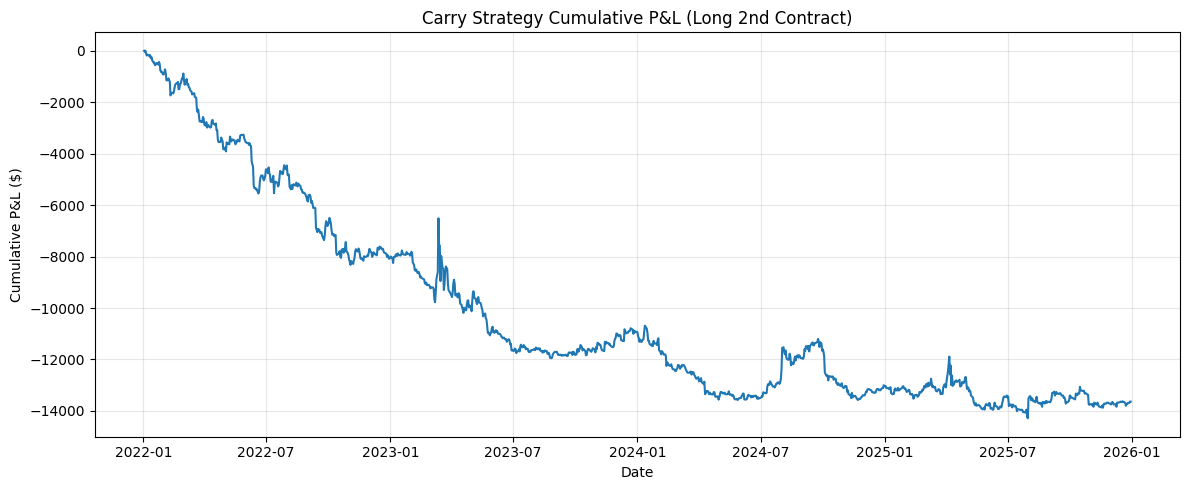

Regime stats:


,regime,cum_pnl,avg_daily,std_daily,n_obs,sharpe
0,Hiking,-11625.0,-23.676171,206.069025,491,-1.823892
1,Plateau/Cutting,-2012.5,-2.672643,116.911311,753,-0.362898


Enhanced strategy:
Cumulative P&L: -8687.5
Sharpe ratio: -1.296
Max drawdown: -9587.5


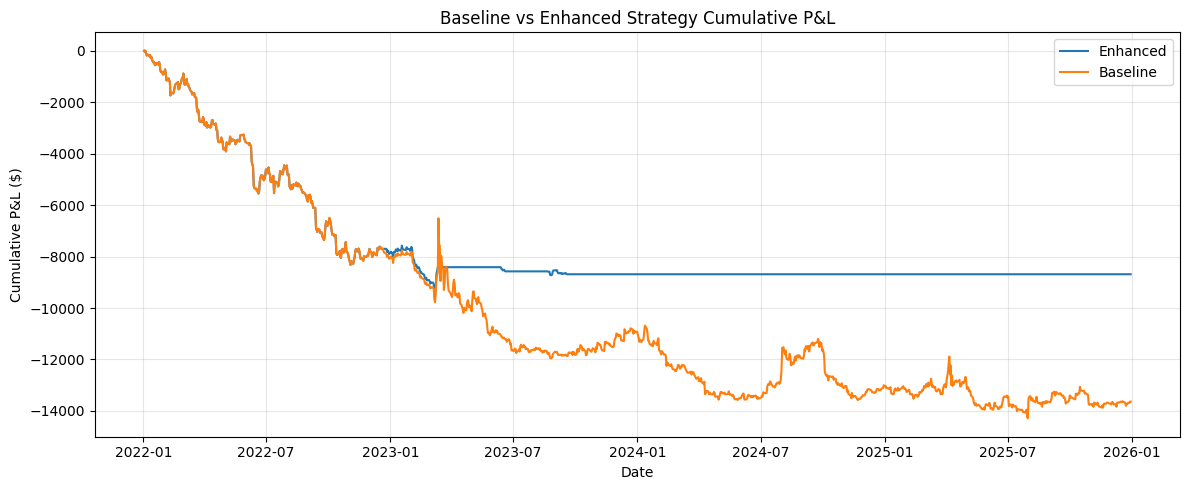

In [ ]:
# Q6: Trading Strategy
# Uses objects created in the Data Preview section: sofr_rates, contract_info, figsize

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Verify labels in sofr_rates (do not assume) ---
if 'date' in sofr_rates.columns:
    sofr_rates = sofr_rates.set_index('date')

contract_cols = list(sofr_rates.columns)
expiry_map = dict(zip(contract_info['ticker'], contract_info['expiry_date']))

# Helper: get ordered contracts by expiry for a given date

def ordered_contracts(asof_date):
    future_contracts = [(t, d) for t, d in expiry_map.items() if pd.notna(d) and d.date() > asof_date.date()]
    future_contracts = [t for t in future_contracts if t[0] in contract_cols]
    return sorted(future_contracts, key=lambda x: x[1])

# Build strategy: long 2nd contract, roll when it becomes front
rows = []
prev_rate = None
prev_contract = None

for dt in sofr_rates.index:
    oc = ordered_contracts(dt)
    if len(oc) < 2:
        continue
    contract = oc[1][0]  # 2nd contract
    rate = sofr_rates.at[dt, contract]
    if pd.isna(rate):
        continue

    # Daily P&L based on rate change in held contract
    if prev_rate is None or prev_contract != contract:
        pnl = 0.0  # no pnl on roll day (reset)
    else:
        pnl = -(rate - prev_rate) * 100 * 25  # DV01 = $25 per bp, rate in %

    rows.append({
        'date': dt,
        'contract': contract,
        'rate': rate,
        'pnl': pnl
    })

    prev_rate = rate
    prev_contract = contract

strategy = pd.DataFrame(rows).set_index('date')
strategy['cum_pnl'] = strategy['pnl'].cumsum()

# Performance metrics
avg_daily = strategy['pnl'].mean()
std_daily = strategy['pnl'].std()
sharpe = (avg_daily / std_daily) * np.sqrt(252) if std_daily != 0 else np.nan

# Max drawdown
cum = strategy['cum_pnl']
roll_max = cum.cummax()
drawdown = cum - roll_max
max_dd = drawdown.min()

print('Cumulative P&L:', round(strategy['cum_pnl'].iloc[-1], 2))
print('Sharpe ratio:', round(sharpe, 3))
print('Max drawdown:', round(max_dd, 2))

# Plot cumulative P&L
fig, ax = plt.subplots(figsize=figsize)
ax.plot(strategy.index, strategy['cum_pnl'])
ax.set_title('Carry Strategy Cumulative P&L (Long 2nd Contract)')
ax.set_xlabel('Date')
ax.set_ylabel('Cumulative P&L ($)')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Regime-conditional performance
strategy['regime'] = np.where(strategy.index <= pd.Timestamp('2023-07-31'), 'Hiking', 'Plateau/Cutting')
regime_stats = strategy.groupby('regime').agg(
    cum_pnl=('pnl', 'sum'),
    avg_daily=('pnl', 'mean'),
    std_daily=('pnl', 'std'),
    n_obs=('pnl', 'count')
).reset_index()
regime_stats['sharpe'] = (regime_stats['avg_daily'] / regime_stats['std_daily']) * np.sqrt(252)

print('Regime stats:')
display(regime_stats)

# --- Enhancement: only hold when curve is upward sloping (2nd > 1st contract) ---
rows = []
prev_rate = None
prev_contract = None

for dt in sofr_rates.index:
    oc = ordered_contracts(dt)
    if len(oc) < 2:
        continue
    c1 = oc[0][0]
    c2 = oc[1][0]
    r1 = sofr_rates.at[dt, c1]
    r2 = sofr_rates.at[dt, c2]
    if pd.isna(r1) or pd.isna(r2):
        continue

    # Signal: hold only if curve is upward sloping
    hold = r2 >= r1
    contract = c2
    rate = r2

    if not hold:
        pnl = 0.0
        prev_rate = None
        prev_contract = None
    else:
        if prev_rate is None or prev_contract != contract:
            pnl = 0.0
        else:
            pnl = -(rate - prev_rate) * 100 * 25
        prev_rate = rate
        prev_contract = contract

    rows.append({'date': dt, 'pnl': pnl})

enh = pd.DataFrame(rows).set_index('date')
enh['cum_pnl'] = enh['pnl'].cumsum()

avg_daily = enh['pnl'].mean()
std_daily = enh['pnl'].std()
sharpe = (avg_daily / std_daily) * np.sqrt(252) if std_daily != 0 else np.nan

cum = enh['cum_pnl']
roll_max = cum.cummax()
drawdown = cum - roll_max
max_dd = drawdown.min()

print('Enhanced strategy:')
print('Cumulative P&L:', round(enh['cum_pnl'].iloc[-1], 2))
print('Sharpe ratio:', round(sharpe, 3))
print('Max drawdown:', round(max_dd, 2))

fig, ax = plt.subplots(figsize=figsize)
ax.plot(enh.index, enh['cum_pnl'], label='Enhanced')
ax.plot(strategy.index, strategy['cum_pnl'], label='Baseline')
ax.set_title('Baseline vs Enhanced Strategy Cumulative P&L')
ax.set_xlabel('Date')
ax.set_ylabel('Cumulative P&L ($)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Limitations (discussion prompt): transaction costs, bid-ask, margin, roll timing, liquidity.



---

## Your Analysis

*Begin your work below. Add cells as needed.*

In [ ]:
# Your analysis here